<a href="https://colab.research.google.com/github/bobby-he/bayesian-ntk/blob/master/toy_1d_example.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Imports and plot utils

In [1]:
import os
from getpass import getpass
user = getpass('GitHub user')
password = getpass('GitHub password')
os.environ['GITHUB_AUTH'] = user + ':' + password
!git clone https://$GITHUB_AUTH@github.com/bobby-he/bayesian-ntk.git

GitHub user··········
GitHub password··········
Cloning into 'bayesian-ntk'...
remote: Enumerating objects: 31, done.
remote: Counting objects: 100% (31/31), done.
remote: Compressing objects: 100% (21/21), done.
remote: Total 31 (delta 6), reused 24 (delta 4), pack-reused 0
Unpacking objects: 100% (31/31), done.


In [2]:
%cd bayesian-ntk/bayesian_ntk

/content/bayesian-ntk/bayesian_ntk


In [3]:
!pip install -q git+https://www.github.com/google/neural-tangents

In [0]:
import jax.numpy as np
from jax import random
from jax import vmap

import functools

from utils import get_toy_data
from models import homoscedastic_model
from train import train_model
import nt_predict_copy
import config

from IPython.display import set_matplotlib_formats
set_matplotlib_formats('pdf', 'svg')
import matplotlib
import seaborn as sns
# sns.set(font_scale=1.3)
# sns.set_style("darkgrid", {"axes.facecolor": ".95"})
import matplotlib.pyplot as plt

In [0]:
def format_plot(x=None, y=None):
    ax = plt.gca()
    if x is not None:
        plt.xlabel(x, fontsize=20)
    if y is not None:
        plt.ylabel(y, fontsize=20)

def finalize_plot(shape=(1, 1)):
    plt.gcf().set_size_inches(
        shape[0] * 1.5 * plt.gcf().get_size_inches()[1],
        shape[1] * 1.5 * plt.gcf().get_size_inches()[1])
    plt.tight_layout()
    
def plot_fn(train, test, *fs):
    train_xs, train_ys = train

    plt.plot(train_xs, train_ys, 'go', markersize=7, label='train')

    if test != None:
        test_xs, test_ys = test
        plt.plot(test_xs, test_ys, 'k--', linewidth=3, label='$x\mathrm{sin}(x)$')

        for f in fs:
            plt.plot(test_xs, f(test_xs), '-', linewidth=3)
    plt.xlim([-np.pi, np.pi])
    plt.ylim([-1.5, 1.5])

    format_plot('$x$', '$y$')


# Toy 1d example notebook

The purpose of this notebook will be to demonstrate how to train Bayesian Deep Ensembles with the package, bayesian-ntk, by going through the toy homoscedastic regression example from our NeurIPS 2020 submission: 'Bayesian Deep Ensembles via the Neural Tangent Kernel'. The package builds on top of the [Neural Tangents](https://github.com/google/neural-tangents) library in [JAX](https://github.com/google/jax).

The package stores default config files in `config.py`. For example, our default NN baselearner models will have the following config:


In [45]:
model_config = config.get_model_config('default')
print(model_config)

{'W_std': 1.5, 'b_std': 0.05, 'width': 512, 'depth': 2}


In [0]:
_, _, kernel_fn = homoscedastic_model( parameterization = 'ntk', **model_config)

In [0]:
data_config = config.get_data_config('default')

In [0]:
key = random.PRNGKey(10)

In [0]:
train_data, test_data = get_toy_data(key, config.NOISE_SCALE, **data_config)

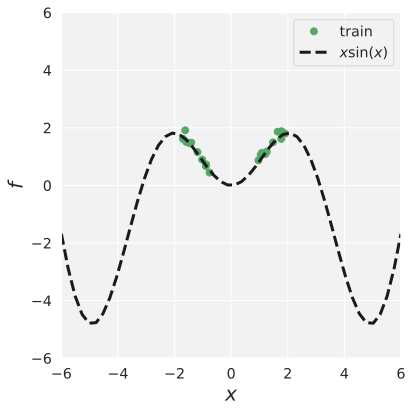

In [42]:
plot_fn(train_data, test_data)
format_plot('$x$', '$f$')
plt.legend()

plt.xlim([-6., 6.])
plt.ylim([-6., 6.])

finalize_plot((1,1))


In [13]:
analytic_ntkgp_moments, analytic_nngp_moments = nt_predict_copy.gp_inference_copy(
    kernel_fn = kernel_fn,
    x_train = train_data.inputs,
    y_train = train_data.labels,
    x_test = test_data.inputs,
    get = ['ntk', 'nngp'],
    diag_reg = config.NOISE_SCALE**2,
    compute_cov = True
)

/usr/local/lib/python3.6/dist-packages/jax/lax/lax.py:5222: UserWarning: Explicitly requested dtype <class 'jax.numpy.lax_numpy.float64'> requested in astype is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  warnings.warn(msg.format(dtype, fun_name , truncated_dtype))


In [0]:
results_dict = {
    'NTKGP analytic': analytic_ntkgp_moments,
    'NNGP analytic': analytic_nngp_moments
}

In [0]:
ensemble_methods_list = ['Deep ensemble', 'RP-param', 'NTKGP-param']

In [0]:
train_config = config.get_train_config('default')
ensemble_key = random.split(key, config.ENSEMBLE_SIZE)
train_baselearner = lambda key, train_method: train_model(key, train_method, train_data, test_data, parameterization = 'standard', **train_config)
train_ensemble = lambda train_method: vmap(train_baselearner, (0, None))(ensemble_key, train_method)


In [0]:
for method in ensemble_methods_list:
    method_input_str = config.method_input_dict[method]
    print(f"Starting ensemble training for  {method} method")
    baselearners_test_pred = train_ensemble(method_input_str)
    ensemble_mean = np.mean(baselearners_test_pred, axis = 0).reshape(-1,)
    ensemble_var = np.var(baselearners_test_pred, axis = 0, ddof = 1).reshape(-1,)
    ensemble_std = np.sqrt(ensemble_var + config.NOISE_SCALE ** 2)
    results_dict.update(
        {
            method: config.Gaussian(ensemble_mean, ensemble_std)
        }
    )


In [0]:
plot_method_list = ['NNGP analytic'] + ensemble_methods_list

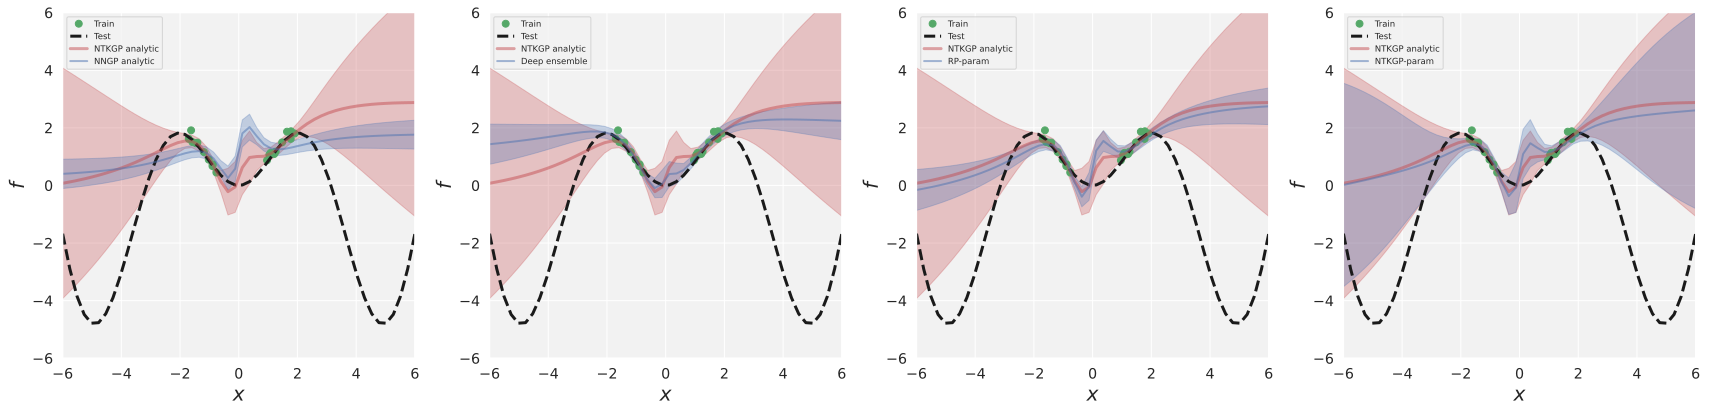

In [32]:
legend = functools.partial(plt.legend, fontsize=8.5)
for plt_idx in range(1, 5):
    plt.subplot(1, 4, plt_idx)
    plot_fn(train_data, test_data)
    
    ntkgp_moments = results_dict['NTKGP analytic']
    ntkgp_means = ntkgp_moments.mean
    ntkgp_stds = ntkgp_moments.standard_deviation
    plt.plot(test_data.inputs, ntkgp_means, 'r-', linewidth = 3, alpha = 0.5)
    plt.fill_between(
        np.reshape(test_data.inputs, (-1,)),
        ntkgp_means - 2 * ntkgp_stds,
        ntkgp_means + 2 * ntkgp_stds,
        color='r',
        alpha = 0.3
    )
    method = plot_method_list[plt_idx - 1]
    method_moments = results_dict[method]
    method_means = method_moments.mean
    method_stds = method_moments.standard_deviation
    plt.plot(test_data.inputs, method_means, 'b-', linewidth = 2, alpha = 0.5)
    plt.fill_between(
        np.reshape(test_data.inputs, (-1,)),
        method_means - 2 * method_stds,
        method_means + 2 * method_stds,
        color='b',
        alpha = 0.3
    )
    
    legend(['Train', 'Test', 'NTKGP analytic', method], loc = 'upper left')
    plt.xlim([-6., 6.])
    plt.ylim([-6., 6.])
    format_plot('$x$', '$f$')
finalize_plot((4,1))
#     plt.plot(test_data.inputs, )

In [20]:
len(train_data.inputs)

20